 89%|███████████████████████████████████████████████████████████████████▍         888/1000 [ETA: 00:28, Elapsed: 03:49]


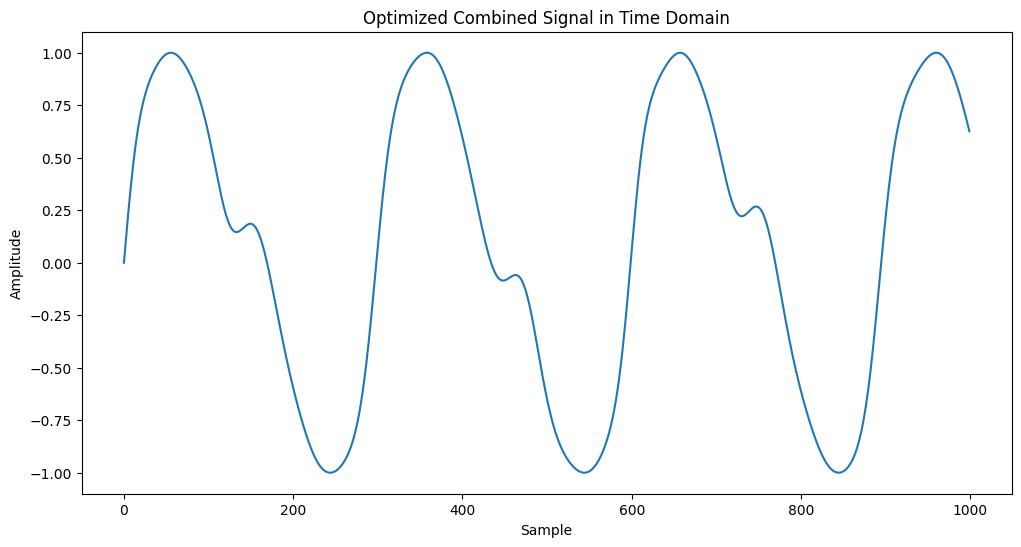

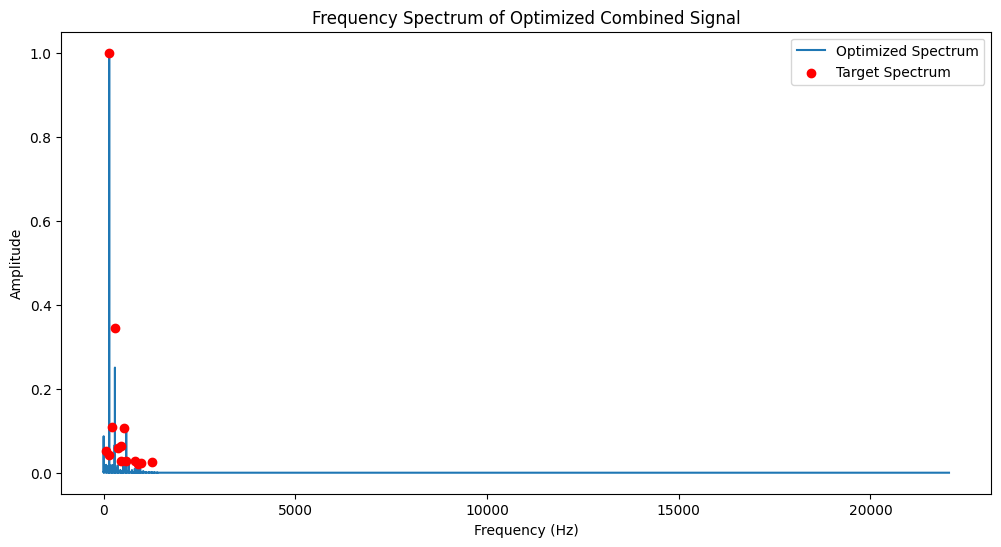

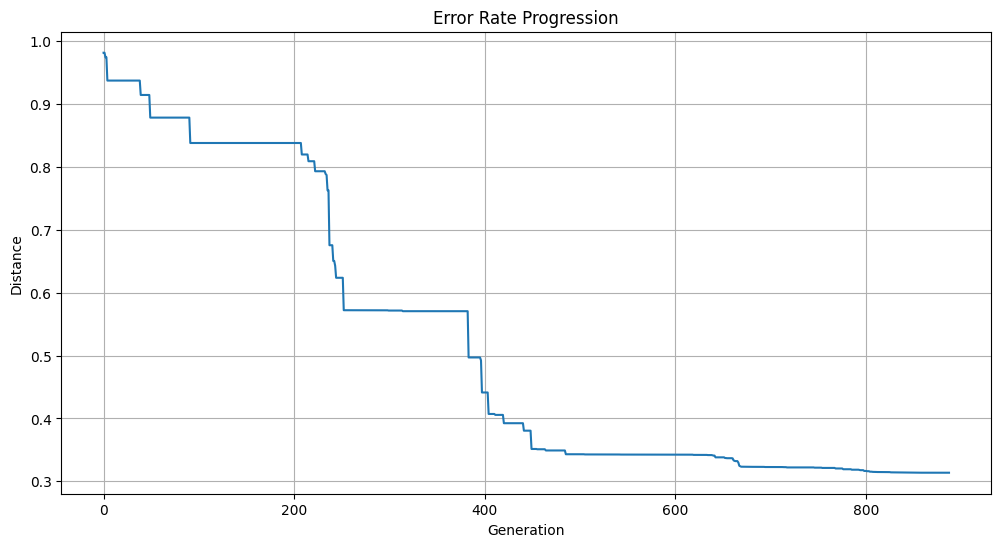

Modulator 4:

    Frequency: 70.21589199666053
    Amplitude: 0.4632975999814919

Modulator 3:

    Frequency: 293.98959262217966
    Amplitude: 0.9112834382783972

Modulator 2:

    Frequency: 150.01178203727082
    Amplitude: 0.4110538658179888

Modulator 1:

    Frequency: 146.99606865634763
    Amplitude: 0.040044033143009194

[2024-08-21 01:09:03] 16-bit wave file with 44.1kHz sampling rate saved successfully to: C:\Users\egorp\Nextcloud\code\public_repos\FFTimbre\optimize_fm\rendered_audio\optimized_output_fm_cellotest.wav


In [3]:
import numpy as np
import pandas as pd
import os
from IPython.display import Audio, display

from fm_synthesis import FMSynthesizer, FMOptimizer
from fm_utils import plot_results, print_optimal_params
from generate_wave_file import generate_wave_file

# Constants and configurations
DURATION = 1.0  # seconds
SAMPLE_RATE = 44100  # samples per second
FILE_PATH = 'tsv/cello_single.tsv'
OUTPUT_FILENAME = 'optimized_output_fm_cellotest.wav'

# Data loading and preprocessing
df = pd.read_csv(FILE_PATH, sep='\t')
frequencies = df['Frequency (Hz)'].values
amplitudes = df['Amplitude'].values
amplitudes /= np.max(amplitudes)

# Instantiate the synthesizer
synth = FMSynthesizer(sample_rate=SAMPLE_RATE, duration=DURATION)

# Instantiate the optimizer. Available methods: kullback_leibler_divergence, itakura_saito, spectral_convergence, cosine_similarity, 
# euclidean_distance, manhattan_distance, pearson_correlation_coefficient, mfcc_distance
optimizer = FMOptimizer(synth, objective_type='cosine_similarity')

# Define bounds for the optimization
bounds = [
    (50, 5000),  # Frequency bounds for osc4
    (0, 15),  # Amplitude bounds for osc4
    (50, 5000),  # Frequency bounds for osc3
    (0, 15),  # Amplitude bounds for osc3
    (50, 5000),  # Frequency bounds for osc2
    (0, 15),  # Amplitude bounds for osc2
    (50, 5000),  # Frequency bounds for osc1
    (0, 15)   # Amplitude bounds for osc1
]

# Run the optimization. Available methods: differential_evolution, dual_annealing, basinhopping
result = optimizer.run_optimization(frequencies, amplitudes, bounds, optimization_method='differential_evolution', n_generations=1000)

# Extract the optimal parameters and error history
optimal_params = result.x
error_history = optimizer.error_history


# Generate the combined signal using the optimal parameters
combined_signal = synth.generate_combined_signal(optimal_params)

# Plot the results
plot_results(combined_signal, frequencies, amplitudes, error_history, SAMPLE_RATE)

# Print the optimal parameters
print_optimal_params(optimal_params)

# Synthesize and save the audio using the provided script
generate_wave_file(combined_signal, SAMPLE_RATE, custom_filename=OUTPUT_FILENAME, save_to_file=True)

# Display the generated audio file
output_path = os.path.join('rendered_audio', OUTPUT_FILENAME)
display(Audio(filename=output_path))


In [2]:
# Define the filename for saving the final values
tsv_filename = 'tsv/final_values_fm.tsv'

# Extract the optimal frequencies and amplitudes
optimal_frequencies = optimal_params[0::2]  # Frequencies are at even indices
optimal_amplitudes = optimal_params[1::2]   # Amplitudes are at odd indices

# Create the DataFrame with the final values
final_values_df = pd.DataFrame({
    'Modulator': [4, 3, 2, 1],  # Modulators are reversed to match the original description
    'Frequency (Hz)': optimal_frequencies,
    'Amplitude': optimal_amplitudes
})

# Display the DataFrame
display(final_values_df)

# Save the DataFrame as a TSV file
final_values_df.to_csv(tsv_filename, sep='\t', index=False)

# Print the location where the TSV file was saved
print(f"TSV file was saved at: {os.path.abspath(tsv_filename)}")


,Modulator,Frequency (Hz),Amplitude
0,4,1366.049632,4.159060
1,3,4248.010168,1.358986
2,2,593.865060,0.117984
3,1,146.993370,0.711046


TSV file was saved at: C:\Users\egorp\Nextcloud\code\public_repos\FFTimbre\optimize_fm\tsv\final_values_fm.tsv
